## Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".

• The project must be carried out in groups of 4 people.
• Use clear and rigorous procedures.
• The delivery of the project is on March 15th, 2024, 11:59 pm, through email with Github link.
• No projects will be received after the delivery time or by any other means than the one established.




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Sample Submission

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import gensim
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, roc_auc_score

In [4]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [5]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Data Preparation

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    #lemmatizer = WordNetLemmatizer()
    #tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Aplica preprocesamiento a la columna 'plot'
dataTraining['plot'] = dataTraining['plot'].apply(preprocess_text)
dataTraining['title'] = dataTesting['plot'].apply(preprocess_text)


In [8]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [9]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2),sublinear_tf=True, min_df=2)
X_dtm = tfidf.fit_transform(dataTraining['plot'])

In [10]:
#tfidf para el tittle
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2),sublinear_tf=True)
if dataTraining['plot'].empty:
  X_dtm_t = tfidf.fit_transform([""])
else:
  X_dtm_t = tfidf.fit_transform(dataTraining['plot'])

In [11]:
from scipy.sparse import hstack
X_combined = hstack([X_dtm, X_dtm_t])

In [12]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_combined, y_genres, test_size=0.20, random_state=41)

Model

In [13]:
# Definir el modelo de Regresión Logística con validación cruzada
clf = OneVsRestClassifier(LogisticRegression(solver='sag', max_iter=15000, random_state=41))

In [14]:
# Entrenar el modelo
clf.fit(X_train, y_train_genres)

# Predecir las probabilidades
y_pred_genres = clf.predict_proba(X_test)


In [15]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro') #0.9012648933414987

0.9012648933414987

**Análisis de resultados por género**

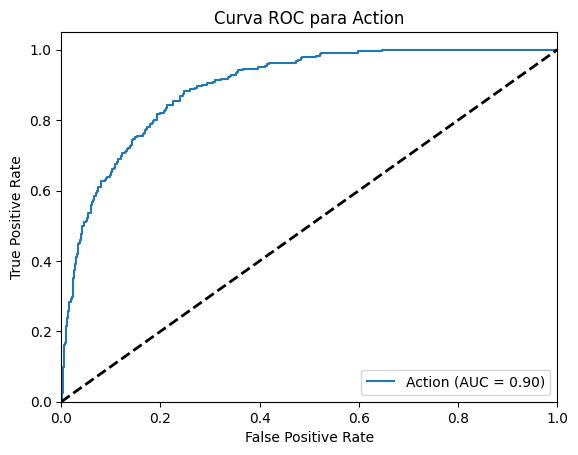

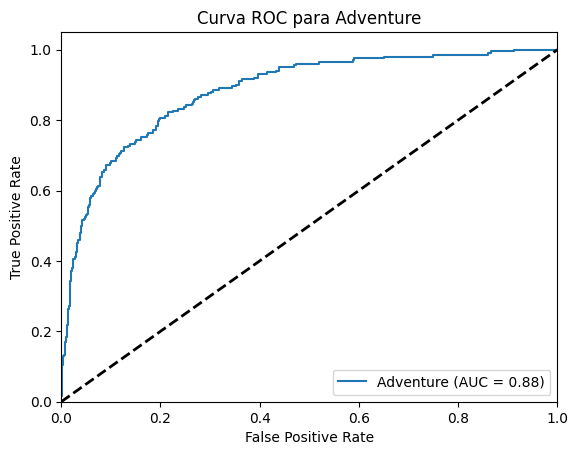

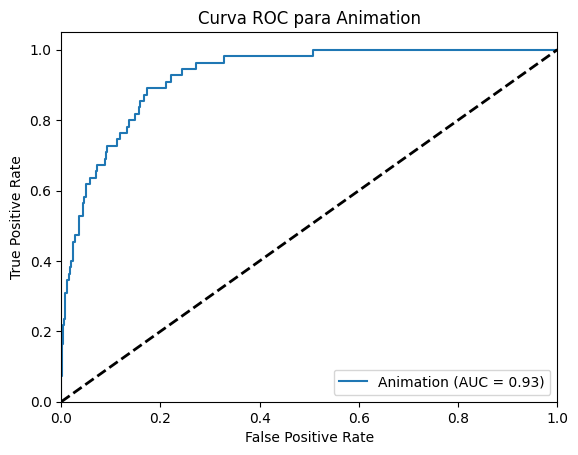

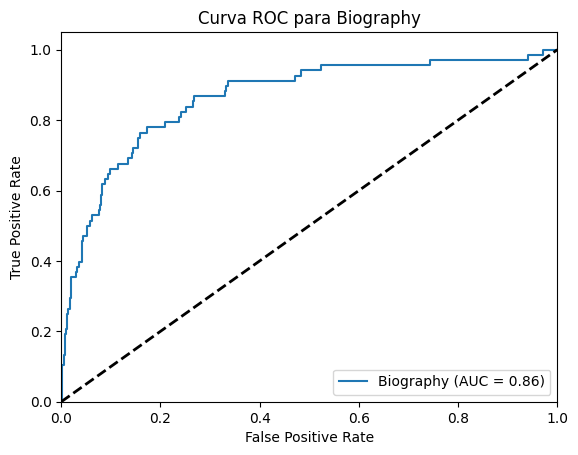

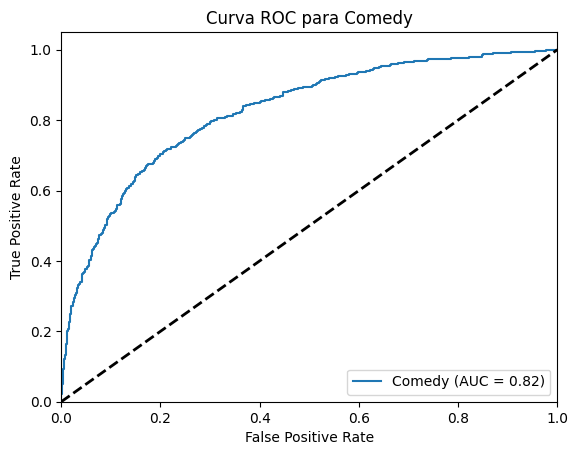

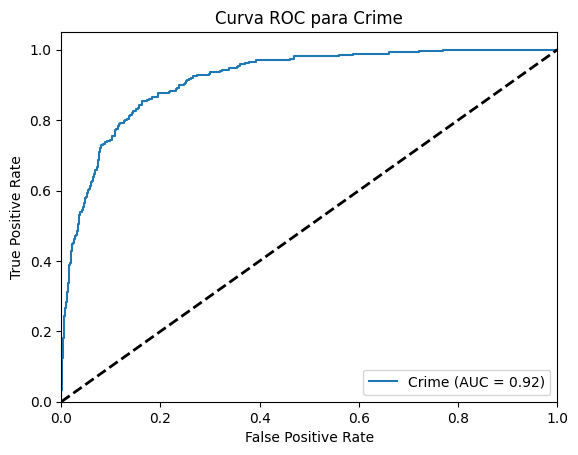

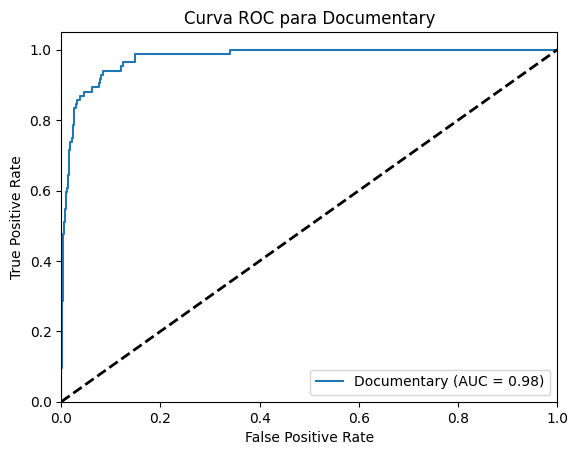

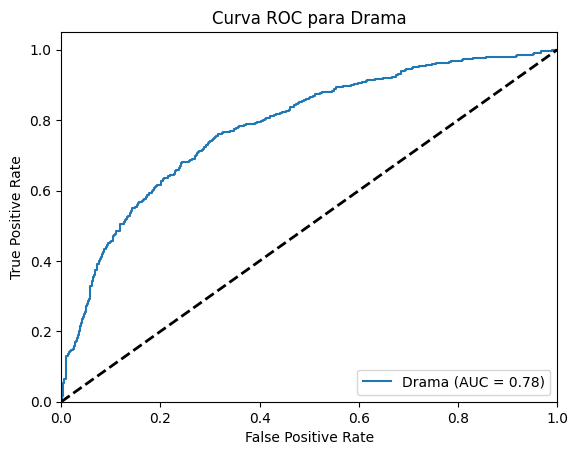

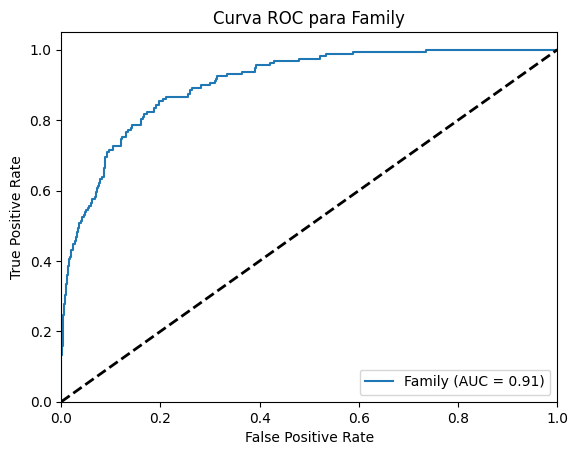

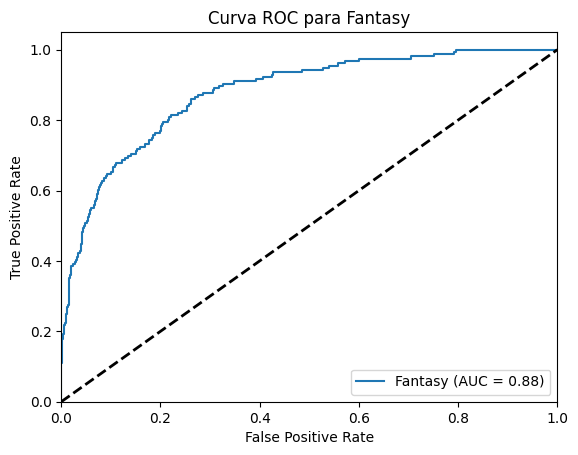

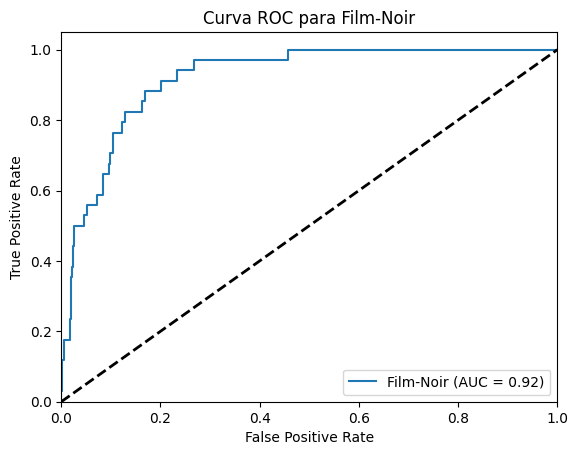

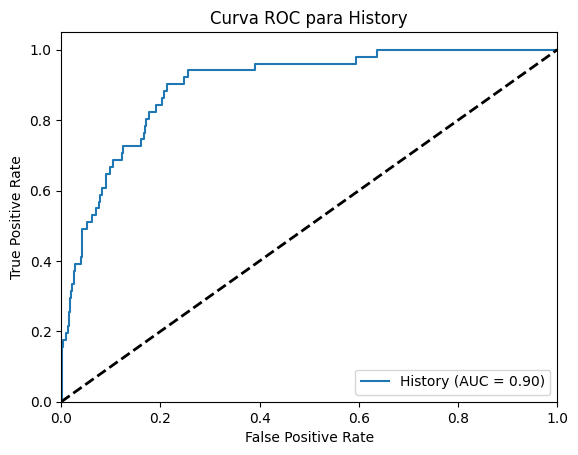

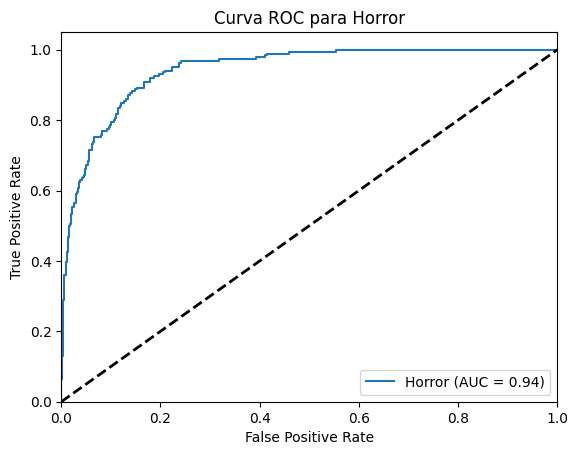

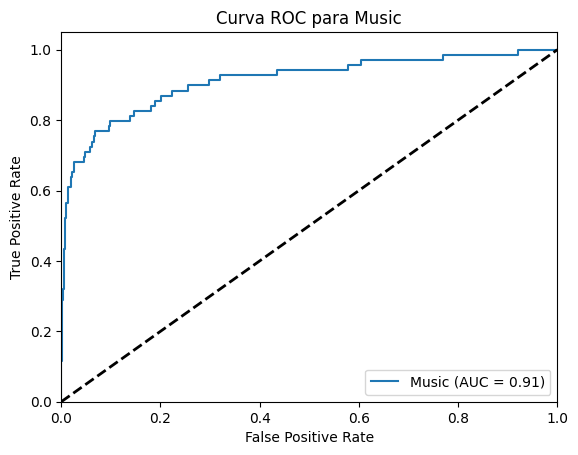

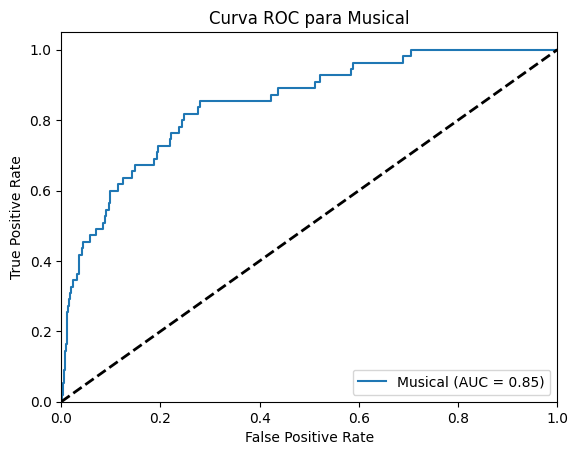

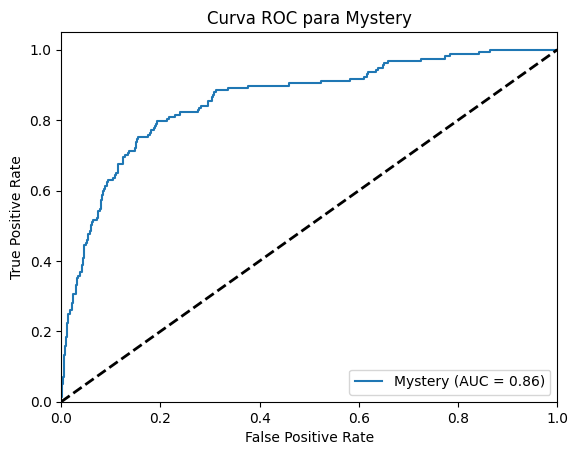

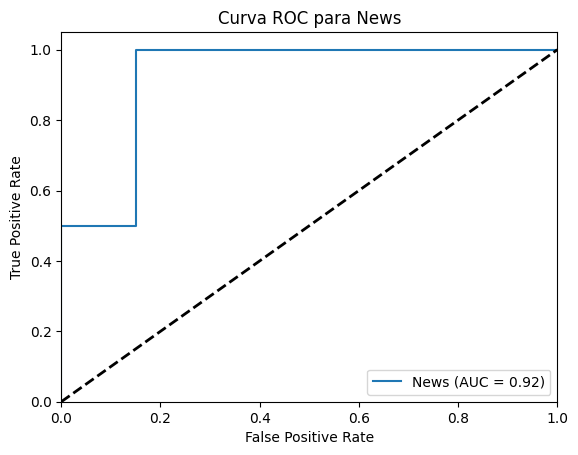

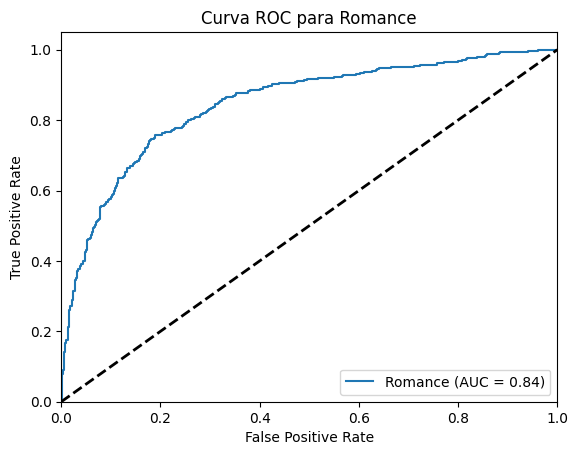

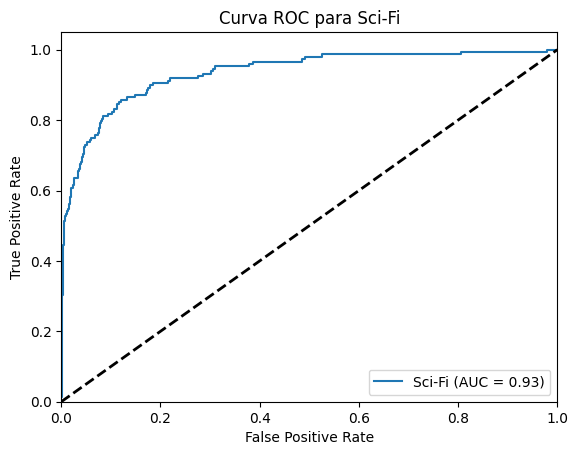

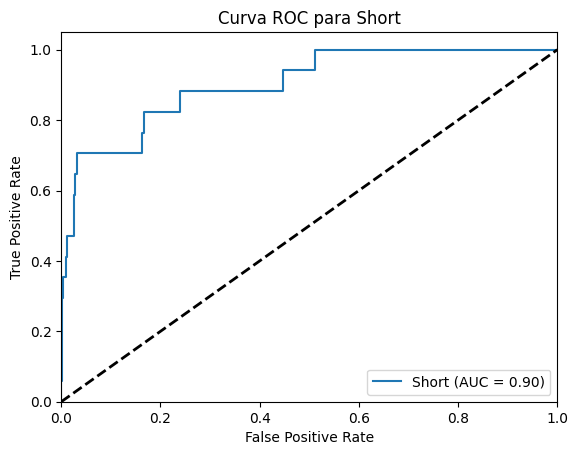

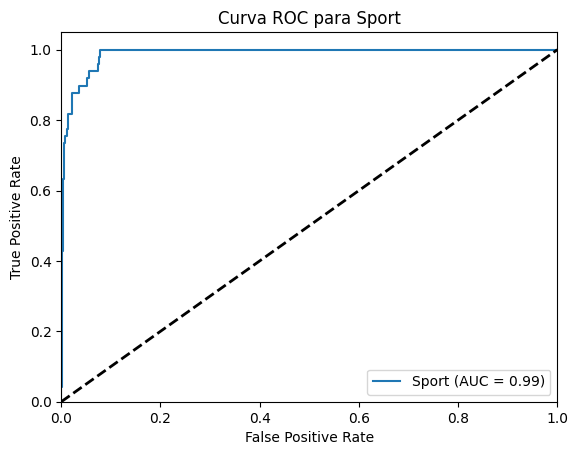

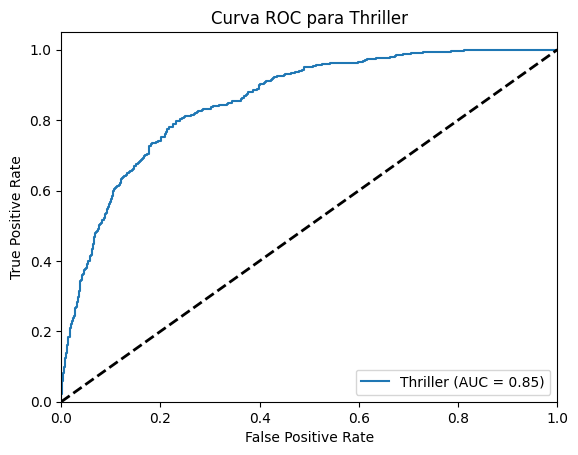

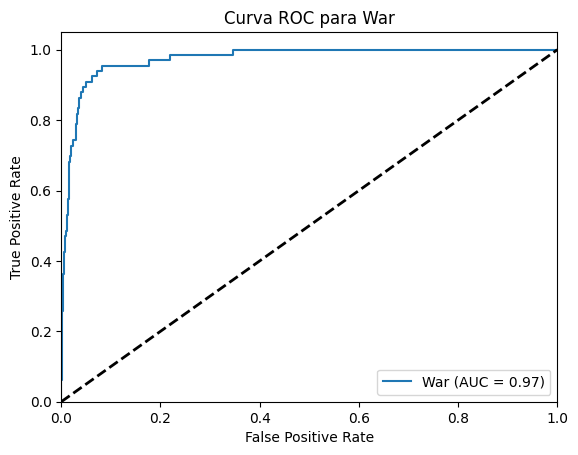

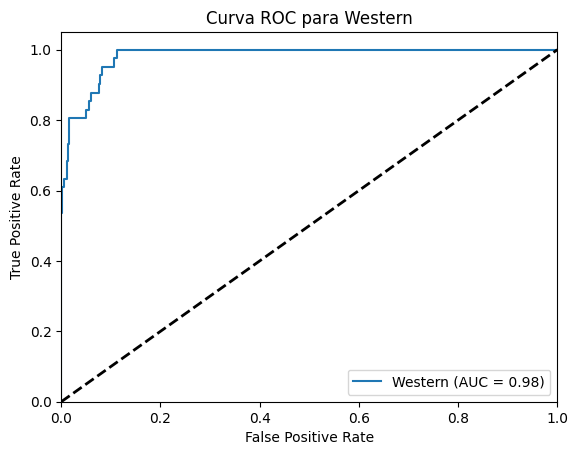

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Para cada género, trazar la curva ROC en gráficos separados
for i, genre in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_genres[:, i], y_pred_genres[:, i])
    roc_auc = auc(fpr, tpr)

    # Crear un nuevo gráfico para cada género
    plt.figure()
    plt.plot(fpr, tpr, label=f'{genre} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC para {genre}')
    plt.legend(loc="lower right")
    plt.show()
